In [1]:
import json
from collections import Counter
from augur.utils import json_to_tree
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### Find mutations that happened during egg-passaging
Use the phylogeny to determine egg-passaging mutations as those that happen on terminal branches leading to an egg-passaged strain

In [3]:
def find_egg_mutations(virus, segment):
    """
    Read in the tree for the virus and segment and 
    find all mutations that happened during egg-passaging
    
    nt and aa muts only, no deletions
    """

        
    tree_file = f'../nextstrain_builds/egg-enriched/auspice/{virus}_{segment.lower()}_egg.json'

    with open(tree_file) as json_handle:
        tree_json = json.load(json_handle)

    tree = json_to_tree(tree_json)
    
    genome_annotations = list(tree_json['meta']['genome_annotations'].keys())
    

    # initialize dictionary to keep track of egg mutations 
    # key is strain name, value is all mutations that happened during egg-passaging
    egg_mutations = {}
    for node in tree.find_clades(terminal=True):
        passage_type = node.node_attrs['passage_category']['value']
        # find egg-passaged tips
        if passage_type == 'egg':
            # initialize this with entry for each coding region on segment
            egg_muts_on_branch = {x: [] for x in genome_annotations}
            # add all observed muts on this branch
            for k,v in node.branch_attrs['mutations'].items():
                v_no_del= [x for x in v if x[-1]!='-']
                egg_muts_on_branch[k] += v_no_del

            egg_mutations[node.name] = egg_muts_on_branch

            
    # save mutation info to json           
    # Serializing json
    json_object_to_save = json.dumps(egg_mutations, indent=2)

    # Write all egg muts for each strain
    with open(f"egg-muts-by-strain/{virus}_{segment}_egg-muts.json", "w") as outfile:
        outfile.write(json_object_to_save)
    
            
    return egg_mutations


In [4]:
viruses = ['h3n2', 'h1n1pdm', 'vic', 'yam']
segments = ['PB1', 'PB2', 'PA', 'HA', 'NP', 'NA', 'MP', 'NS']

for v in viruses:
    for s in segments:
        find_egg_mutations(v, s)

### Find the number of strains with egg-mutations and get the frequency of each mutation amongst egg-passaged strains

In [5]:
def curate_muts(list_of_muts):
    """
    If multiple mutations occur at the same site in the path, 
    take the final genotype.
    Also only care about the final genotype (not what it mutated from), so edit muts accordingly
    """
    
    mut_sites = [int(m[1:-1]) for m in list_of_muts]
    
    #identify positions with multiple mutations
    pos_multi_muts = []
    for pos, count in Counter(mut_sites).items():
        if count>1:
            pos_multi_muts.append(pos)
            
    # now find the initial and final genotypes at this position
    # get all mutations where site only mutated once
    reconiled_list_of_muts = [m[1:] for m in list_of_muts if int(m[1:-1]) not in pos_multi_muts]
    # get all mutations where mutliple occurred at same site
    for x in pos_multi_muts:

        muts_this_site = [m for m in list_of_muts if str(x) in m]
        reconciled_mutation = str(x)+muts_this_site[-1][-1]
        reconiled_list_of_muts.append(reconciled_mutation)

    return reconiled_list_of_muts

In [13]:
def get_egg_mut_freqs(virus, segment, gene):
    """
    Get the frequency of egg mutations amongst egg-passaged strains
        
    Save file with count and frequency of egg muts for each virus/segment
    
    Also save the a version of the mutations-by-strain file with the list of "curated" mutations
    """
    mut_file = f"egg-muts-by-strain/{virus}_{segment}_egg-muts.json"
    
    with open(mut_file) as json_handle:
        egg_muts = json.load(json_handle)
        
    # deal with multiple muts at same site
    egg_mutations = {}
    for strain, muts in egg_muts.items():
        egg_mutations[strain] = {k:curate_muts(v) for k,v in muts.items()}
        
    # save file with "curated" mutation list
    curated_mut_file = f"egg-muts-by-strain/{virus}_{segment}_curated-egg-muts.json"
    curated_muts_json_to_save = json.dumps(egg_mutations, indent=2)

    # Writing to sample.json
    with open(curated_mut_file, "w") as outfile:
        outfile.write(curated_muts_json_to_save)

    total_egg_strains = len(egg_mutations)
    
    # count mutations and calculate their frequency among all egg-passaged strains
    all_muts_gene = [v[gene] for k,v in egg_mutations.items()]
    # count strains with at least one mut in this gene during egg passaging
    strains_w_egg_mut = len([1 for x in all_muts_gene if len(x)!=0])
    percent_w_egg_mut = round(strains_w_egg_mut/total_egg_strains, 4)
    # flatten list of muts to count the most common ones among all strains
    all_muts_gene_flat = [item for items in all_muts_gene for item in items]
    mut_counts = Counter(all_muts_gene_flat).most_common()
    mut_freqs = {i:j/total_egg_strains for i,j in mut_counts}
    
    #filter to just muts occurring in 1% (0r 2.5 or 5) or more of the strains
    egg_muts_above_1percent = {k:round(v,4) for k,v in mut_freqs.items() if v>=0.01}
    egg_muts_above_2_5percent = {k:round(v,4) for k,v in mut_freqs.items() if v>=0.025}
    egg_muts_above_5percent = {k:round(v,4) for k,v in mut_freqs.items() if v>=0.05}
    
    #find how many strains have at least one of these mutations
    higher_freq_muts_01 = list(egg_muts_above_1percent.keys())
    strains_w_higher_freq_egg_muts_01 = len([1 for x in all_muts_gene if set(x).intersection(set(higher_freq_muts_01))])
    percent_w_higher_freq_egg_muts_01 = round(strains_w_higher_freq_egg_muts_01/total_egg_strains, 4)
    
    higher_freq_muts_025 = list(egg_muts_above_2_5percent.keys())
    strains_w_higher_freq_egg_muts_025 = len([1 for x in all_muts_gene if set(x).intersection(set(higher_freq_muts_025))])
    percent_w_higher_freq_egg_muts_025 = round(strains_w_higher_freq_egg_muts_025/total_egg_strains, 4)
    
    higher_freq_muts_05 = list(egg_muts_above_5percent.keys())
    strains_w_higher_freq_egg_muts_05 = len([1 for x in all_muts_gene if set(x).intersection(set(higher_freq_muts_05))])
    percent_w_higher_freq_egg_muts_05 = round(strains_w_higher_freq_egg_muts_05/total_egg_strains, 4)
    
    # condense mutation info by the codon site mutated
    all_mutated_sites = [x[:-1] for x in all_muts_gene_flat]
    mutated_sites_counts = Counter(all_mutated_sites).most_common()
    mutated_sites_freqs = {i:j/total_egg_strains for i,j in mutated_sites_counts}
    
    # filter to just sites that have mutated in 1% of more of strains 
    sites_mutated_above_1percent = {k:round(v,4) for k,v in mutated_sites_freqs.items() if v>=0.01}
    sites_mutated_above_2_5percent = {k:round(v,4) for k,v in mutated_sites_freqs.items() if v>=0.025}
    sites_mutated_above_5percent = {k:round(v,4) for k,v in mutated_sites_freqs.items() if v>=0.05}

    
    egg_count_info_to_save = {'total_num_egg_strains': total_egg_strains, 
                              'percent_w_eggmut_in_gene': percent_w_egg_mut, 
                              'egg_mut_freqs': mut_freqs, 
                              'egg_muts_above_1percent':egg_muts_above_1percent, 
                              'egg_muts_above_2_5percent':egg_muts_above_2_5percent, 
                              'egg_muts_above_5percent':egg_muts_above_5percent, 
                              'percent_w_higherfreq_eggmut_in_gene_01':percent_w_higher_freq_egg_muts_01,
                              'percent_w_higherfreq_eggmut_in_gene_025':percent_w_higher_freq_egg_muts_025, 
                              'percent_w_higherfreq_eggmut_in_gene_05':percent_w_higher_freq_egg_muts_05, 
                              'mutated_sites_freqs': mutated_sites_freqs, 
                              'sites_mutated_above_1percent': sites_mutated_above_1percent, 
                              'sites_mutated_above_2_5percent': sites_mutated_above_2_5percent, 
                              'sites_mutated_above_5percent': sites_mutated_above_5percent}
    
    # save egg mutation count and freq info to json           
    # Serializing json
    json_object_to_save = json.dumps(egg_count_info_to_save, indent=2)

    # Writing json
    with open(f"egg-mut-counts/{virus}_{segment}_{gene}_egg-mut-counts.json", "w") as outfile:
        outfile.write(json_object_to_save)


### Get egg-passaged mutation info for each virus/segment/gene combination to be analyzed

In [14]:
viruses = ['h3n2', 'h1n1pdm', 'vic', 'yam']
segments = ['HA', 'NA', 'PB1', 'PB2', 'PA', 'NP', 'NS', 'MP']
segments_and_genes = {'HA':['SigPep', 'HA1', 'HA2'], 'NA':['NA'], 
                      'PB1':['PB1'], 'PB2':['PB2'], 'PA':['PA'], 
                      'NP':['NP'], 'NS':['NS1'], 'MP': ['M1']} 

In [15]:
for v in viruses:
    for s, gs in segments_and_genes.items():
        for g in gs:
            get_egg_mut_freqs(v,s,g)

### Make summary plot of number of mutations per gene

In [16]:
def get_counts_for_plot(virus, segment, gene, cutoff):
    """
    Retrieve the mutation counts per gene 
    """
    
    eggmut_file = f"egg-mut-counts/{virus}_{segment}_{gene}_egg-mut-counts.json"
    
    with open(eggmut_file) as json_handle:
        egg_mut_info = json.load(json_handle)
    
    percent_w_mut = egg_mut_info['percent_w_eggmut_in_gene']
    
    # get the frequency of strains with only recurrent egg mutations (defined by cutoff)
    percent_w_recurrent_muts = egg_mut_info[f'percent_w_higherfreq_eggmut_in_gene_{cutoff}']

    
    return percent_w_mut, percent_w_recurrent_muts
    

In [17]:
cmap = {'PB2':"#9e0342", 'PB1':"#d53e4f", 'PA': "#f46d43", 
        'HA1': "#66c2a4", 'HA2':"#abdda4", 'NP':"#3388bd", 'NA': "#e6f598", 
        'M1': "#fee08b", 'NS1':"#5e4fa2"}

In [18]:
def plot_eggmut_freq_by_gene(cutoff='025'):
    """
    Plot the percentage of egg-passaged strains that have a mutation in each gene, for each virus
    """
    
    data_to_plot = []
    
    for v in viruses:
        for s, gs in segments_and_genes.items():
            for g in gs:
                # dont plot signal peptide of HA
                if g !='SigPep':
                    percent_w_mut, percent_w_recurrent_muts = get_counts_for_plot(v,s,g, cutoff)
                    data_to_plot.append({'virus': v, 'gene':g, 
                                         'percent_w_mut':percent_w_mut, 
                                         'percent_w_recurrent_muts':percent_w_recurrent_muts})

    df = pd.DataFrame(data_to_plot)
    
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10), sharex=True)
    ax1 = sns.barplot(data=df, x='virus', y='percent_w_mut', hue = 'gene', 
                      hue_order = ['PB2', 'PB1', 'PA', 'HA1', 'HA2', 'NP', 'NA', 'M1', 'NS1'],
                      palette=cmap, ax=ax1)
    ax2 = sns.barplot(data=df, x='virus', y='percent_w_recurrent_muts', hue = 'gene', 
                      hue_order = ['PB2', 'PB1', 'PA', 'HA1', 'HA2', 'NP', 'NA', 'M1', 'NS1'],
                      palette=cmap, ax=ax2)
    
    ax1.get_legend().remove()
    
    ax1.set_title('All egg-passaging mutations', fontsize = 20)
    ax2.set_title(f'Egg adaptive mutations\n(Muts occurring in >={cutoff[-1]}% of egg-passaged strains)', fontsize = 20)
    
    ax1.tick_params(axis='both', labelsize=16)
    ax2.tick_params(axis='both', labelsize=16)
    
    ax1.set_xlabel('')
    ax2.set_xlabel('')
    ax1.set_ylabel('Percent of strains with\nat least one\nmutation during egg-passaging', fontsize=16)
    ax2.set_ylabel('Percent of strains with\nat least one recurrent\negg-passaging mutation', fontsize=16)
    
    sns.despine()
    
    

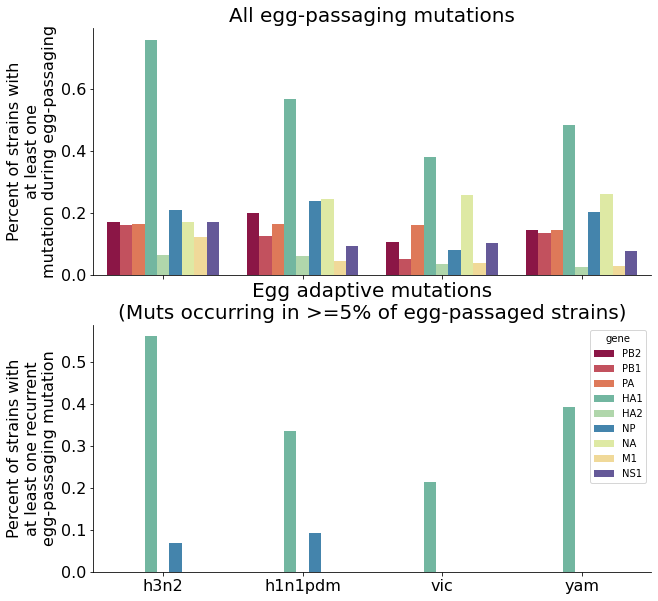

In [19]:
plot_eggmut_freq_by_gene()